# CLFO
## 02 Feed-Forward neural network

### Imports

In [1]:
import sys
sys.executable

'c:\\users\\randj\\appdata\\local\\programs\\python\\python38\\python.exe'

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split as split
import torch 
from torch.utils.data import DataLoader, Dataset
from functions import *
import torch.nn as nn
from matplotlib import pyplot as plt

### Loading prepared data

In [2]:
with open("tr2_grey_256.npy","rb")as f:
    X=np.load(f)
    y=np.load(f)
    

print(np.unique(y,return_counts=True))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(array([0., 1., 2., 3., 4.]), array([1200, 1200, 1200, 1200, 1200], dtype=int64))


In [7]:
#X = X.astype('float32')
y = y.astype('float32')

### Model parameters

In [25]:
input_size=X.shape[1]*X.shape[2]
num_classes=5

test_size=0.2
batch_size=100
learning_rate=0.01
hidden_size=100
num_epochs=10

### Spliting train and test size

In [9]:
X_train, X_test, y_train, y_test = split(X, y, test_size = test_size, random_state = 7)

In [10]:
np.unique(y_test, return_counts = True)

(array([0., 1., 2., 3., 4.], dtype=float32),
 array([230, 224, 253, 248, 245], dtype=int64))

### Transform two numpy arrays into one torch Data instance

In [11]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(y)
        self.samples=X.shape[0]
        self.features=X.shape[1]*X.shape[2]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.samples

### Creating data instance

In [12]:
train_data=Data(X_train, y_train)
test_data=Data(X_test,y_test)

In [13]:
train_data.samples, test_data.samples

(4800, 1200)

In [14]:
train_data[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 1.]]),
 tensor(2.))

In [15]:
train_data.features

65536

### Devide train and test data in 100 samples batches

In [16]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size)

### Example

In [17]:
examples=iter(train_loader)
samples, labels = examples.next()
samples = samples.reshape((100, 1, 256, 256))
print(samples.shape, labels)

torch.Size([100, 1, 256, 256]) tensor([3., 1., 2., 4., 1., 3., 3., 4., 4., 3., 4., 2., 4., 3., 2., 0., 0., 3.,
        2., 2., 0., 0., 1., 3., 3., 3., 0., 3., 3., 2., 4., 1., 2., 0., 1., 2.,
        2., 2., 0., 3., 1., 4., 3., 0., 0., 4., 1., 1., 4., 3., 0., 1., 1., 1.,
        1., 2., 0., 2., 2., 0., 0., 2., 4., 0., 1., 0., 0., 4., 1., 4., 2., 1.,
        2., 4., 0., 3., 3., 0., 1., 0., 2., 0., 1., 1., 1., 3., 3., 0., 3., 4.,
        4., 3., 0., 0., 0., 3., 2., 2., 3., 1.])


### Allow GPU usage

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
samples

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[2., 3., 3.,  ..., 0., 0., 0.],
          [4., 2., 3.,  ..., 0., 0., 0.],
          [3., 3., 3.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 2., 3., 2.],
          [0., 0., 0.,  ..., 2., 3., 2.],
          [0., 0., 0.,  ..., 2., 3., 2.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 1., 0.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 1., 1.],
          [0., 1., 1.,  ..., 0., 1., 2.],
          ...,
          [1., 2., 1.,  ..., 0.

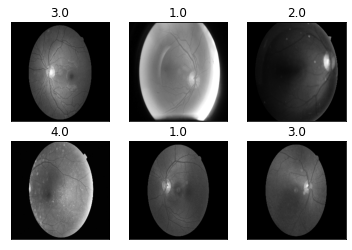

In [20]:
for i in range(6):
    ax = plt.subplot(2,3,i+1, title = f'{labels[i]}') 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

In [26]:
# training class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
            
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
        
model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# train
n_total_steps = len(train_loader)
print(n_total_steps)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 256, 256 > 100, 256 * 256
        # to device - to GPU if exists
        images = images.reshape(-1, 256*256).to(device) 
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 8 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

# test
with torch.no_grad():
    n_corect = 0
    n_samples = 0
    for images, labels in test_loader:        
        images = images.reshape(-1, 256*256).to(device) 
        labels = labels.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_corect += (predictions == labels).sum().item()
        
    acc = 100 * n_corect / n_samples
    
    print(f'accuracy: {acc}%')       

48
epoch 1 / 10, step 8/48, loss = 11151.8037
epoch 1 / 10, step 16/48, loss = 6680.1880
epoch 1 / 10, step 24/48, loss = 1172.3539
epoch 1 / 10, step 32/48, loss = 1.6711
epoch 1 / 10, step 40/48, loss = 1.6164
epoch 1 / 10, step 48/48, loss = 1.6100
epoch 2 / 10, step 8/48, loss = 1.6123
epoch 2 / 10, step 16/48, loss = 1.6115
epoch 2 / 10, step 24/48, loss = 1.6175
epoch 2 / 10, step 32/48, loss = 1.6026
epoch 2 / 10, step 40/48, loss = 1.6104
epoch 2 / 10, step 48/48, loss = 1.6075
epoch 3 / 10, step 8/48, loss = 1.6058
epoch 3 / 10, step 16/48, loss = 1.6108
epoch 3 / 10, step 24/48, loss = 1.6097
epoch 3 / 10, step 32/48, loss = 1.6098
epoch 3 / 10, step 40/48, loss = 1.6120
epoch 3 / 10, step 48/48, loss = 1.6053
epoch 4 / 10, step 8/48, loss = 1.6073
epoch 4 / 10, step 16/48, loss = 1.6084
epoch 4 / 10, step 24/48, loss = 1.6112
epoch 4 / 10, step 32/48, loss = 1.6113
epoch 4 / 10, step 40/48, loss = 1.6101
epoch 4 / 10, step 48/48, loss = 1.6090
epoch 5 / 10, step 8/48, loss =